<a href="https://colab.research.google.com/github/azhgh22/Walmart-Recruiting-Store-Sales-Forecasting/blob/main/notebooks/n_beats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Set up env**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import userdata
token = userdata.get('GITHUB_TOKEN')
user_name = userdata.get('GITHUB_USERNAME')
mail = userdata.get('GITHUB_MAIL')

!git config --global user.name "{user_name}"
!git config --global user.email "{mail}"
!git clone https://{token}@github.com/azhgh22/Walmart-Recruiting-Store-Sales-Forecasting.git

%cd Walmart-Recruiting-Store-Sales-Forecasting

Cloning into 'Walmart-Recruiting-Store-Sales-Forecasting'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 301 (delta 42), reused 37 (delta 15), pack-reused 209 (from 1)
Receiving objects: 100% (301/301), 6.72 MiB | 32.47 MiB/s, done.
Resolving deltas: 100% (139/139), done.
/content/Walmart-Recruiting-Store-Sales-Forecasting


In [3]:
from google.colab import userdata
! pip install -r ./requirements.txt
kaggle_json_path = userdata.get('KAGGLE_JSON_PATH')
! ./src/data_loader.sh -f {kaggle_json_path}

INFO: pip is looking at multiple versions of nbeats-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/

Setting up Kaggle credentials...
Ensuring data directory exists at 'data/'...
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 871MB/s]
Unzipping files...
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
Data downloaded and extracted successfully to 'data/'.


# **Torch**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [195]:
from src.config import *

stores = pd.read_csv(STORES_PATH)
features = pd.read_csv(FEATURES_PATH)
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [201]:
# data = train[(train['Store']==1) & (train['Dept']==1)].copy()
train['Date'] = pd.to_datetime(train.Date)

In [202]:
from src.processing import split_data
x_train,y_train,x_val,y_val = split_data(train)

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from nbeats_pytorch.model import NBeatsNet


## Example

In [ ]:
class PatchTSTRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_chunk_length=52, output_chunk_length=39, epochs=10, batch_size=32):
        self.input_chunk_length = input_chunk_length
        self.output_chunk_length = output_chunk_length
        self.epochs = epochs
        self.batch_size = batch_size

    def fit(self, X, y):
        df = X.copy()
        df["y"] = y.values

        if not isinstance(df.index, pd.MultiIndex):
            raise ValueError("X must have a MultiIndex")

        df = df.reset_index()
        df.rename(columns={"Date": "ds"}, inplace=True)
        df["unique_id"] = df["Store"].astype(str) + "_" + df["Dept"].astype(str)

        self.train_df_ = df[["unique_id", "ds", "y"]].copy()

        model = PatchTST(
            input_size=self.input_chunk_length,
            h=self.output_chunk_length,
            max_steps=self.epochs * 104,
            batch_size=self.batch_size,
            random_seed=42
        )

        self.nf_ = NeuralForecast(models=[model], freq="W-FRI")
        self.nf_.fit(df=self.train_df_)
        return self

    def predict(self, X):
        df = X.reset_index()
        df.rename(columns={"Date": "ds"}, inplace=True)
        df["unique_id"] = df["Store"].astype(str) + "_" + df["Dept"].astype(str)

        forecast_df = self.nf_.predict()
        forecast_df = forecast_df.rename(columns={"PatchTST": "y_hat"})

        merged = df.merge(forecast_df, on=["unique_id", "ds"], how="left")
        preds = pd.Series(data=merged["y_hat"].fillna(0).values, index=X.index)

        return preds.to_numpy()

## **Data creation**

In [204]:
def create_data_nbeats(x_train:pd.DataFrame,y_train:pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame()

    df = df.reset_index()
    df["Date"] = x_train.Date
    df["Store"] = x_train.Store
    df["Dept"] = x_train.Dept
    df["y"] = y_train.values

    df.rename(columns={"Date": "ds"}, inplace=True)
    df["unique_id"] = df["Store"].astype(str) + "_" + df["Dept"].astype(str)

    df = df[["unique_id", "ds", "y"]].copy()
    df = df.sort_values(by=["ds"])
    # df.reset_index(drop=True, inplace=True)
    return df

In [211]:
import torch
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MSE
import logging

df = create_data_nbeats(x_train,y_train)

model = NBEATS(
    h=48,
    input_size=52,
    loss=MSE(),
    max_steps=10*104,
    batch_size=32,
    learning_rate=0.001,
    shared_weights=True,
    stack_types=('identity','trend','identity','seasonality', 'identity','identity'),
    n_blocks = [3,3,3,3,3,3],
    random_seed=42,
    accelerator='gpu',     # <--- Correct: This is an NBEATS argument now
    devices=1,             # <--- Correct: This is an NBEATS argument now
    logger=False,          # <--- Correct: This is an NBEATS argument now
    enable_progress_bar=False,
    enable_model_summary=False

)
nf = NeuralForecast(models=[model], freq='W-FRI')
nf.fit(df)


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1040` reached.


In [213]:
preds = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [217]:
print(preds.shape)
print(x_val.shape)

(157728, 3)
(142485, 4)


In [48]:
from src.utils import wmae

In [165]:
real = create_data_nbeats(x_val,y_val)
merged = pd.merge(real, preds, on=)
holidays = x_val['IsHoliday']
wmae(y_val,forecast.predict(x_val),holidays)
# forecast.predict(x_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

np.float64(9853.631339192707)

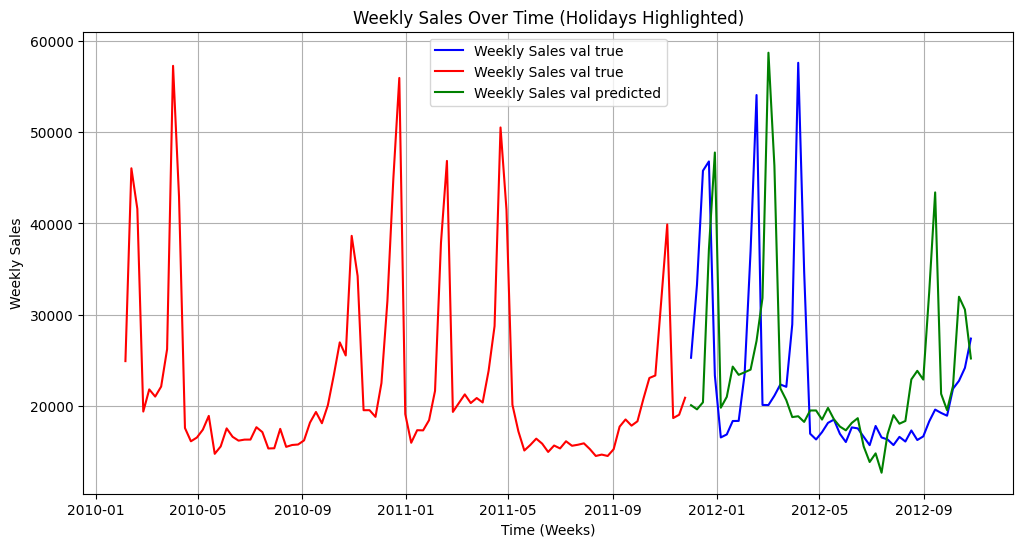

In [130]:
plt.figure(figsize=(12, 6))
plt.plot(x_val.Date, y_val, label='Weekly Sales val true', color='blue')
plt.plot(x_train.Date, y_train, label='Weekly Sales val true', color='red')
plt.plot(x_val.Date, forecast.NBEATS, label='Weekly Sales val predicted', color='green')
# plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()